## Основная часть

### Загрузка данных

In [1]:
import pandas as pd

# Загружаем файл
df = pd.read_excel("Семья_дети.xlsx", sheet_name="98100124")

In [2]:
# Фильтрация только за 2021 год и агрегированных строк
df_filtered = df[
    (df["REF_DATE"] == 2021) &
    (df["Age of youngest child (6)"] == "Age of youngest child")
]

# 2️⃣ Берем нужные столбцы
df_filtered = df_filtered[[
    "GEO",
    "Census family structure including detailed information on stepfamilies (15)",
    "Number of children (5):Average number of children[5]"
]].rename(columns={
    "GEO": "Регион",
    "Census family structure including detailed information on stepfamilies (15)": "Family_Type",
    "Number of children (5):Average number of children[5]": "Среднее кол-во детей"
})


# 3️⃣ Преобразуем тип (на всякий случай)
df_filtered["Среднее кол-во детей"] = pd.to_numeric(df_filtered["Среднее кол-во детей"], errors="coerce")


# Переименовываем для удобства
df_filtered = df_filtered.rename(columns={
    "GEO": "Регион",
    "Census family structure including detailed information on stepfamilies (15)": "Family_Type",
    "Number of children (5):Average number of children[5]": "Среднее кол-во детей"
})

# 4️⃣ Создаём отдельные датасеты по типам семьи
married_df = (
    df_filtered[df_filtered["Family_Type"] == "Total - Married-couple families"]
    .groupby("Регион", as_index=False)["Среднее кол-во детей"]
    .mean()
)

commonlaw_df = (
    df_filtered[df_filtered["Family_Type"] == "Total - Common-law-couple families"]
    .groupby("Регион", as_index=False)["Среднее кол-во детей"]
    .mean()
)

In [3]:
# Проверим, что получилось
print("👰‍♀️ Married-couple families:")
display(married_df)

print("\n💑 Common-law-couple families:")
display(commonlaw_df)

👰‍♀️ Married-couple families:


,Регион,Среднее кол-во детей
0,"Abbotsford - Mission (CMA), B.C.",2.000000
1,Alberta,1.933333
2,"Alma (CA), Que.",1.866667
3,"Amos (CA), Que.",1.966667
4,"Baie-Comeau (CA), Que.",1.700000
...,...,...
161,"Wood Buffalo (CA), Alta.",1.866667
162,"Woodstock (CA), Ont.",1.866667
163,"Yellowknife (CA), N.W.T.",1.866667
164,"Yorkton (CA), Sask.",1.900000



💑 Common-law-couple families:


,Регион,Среднее кол-во детей
0,"Abbotsford - Mission (CMA), B.C.",1.800000
1,Alberta,1.800000
2,"Alma (CA), Que.",1.833333
3,"Amos (CA), Que.",1.933333
4,"Baie-Comeau (CA), Que.",1.733333
...,...,...
161,"Wood Buffalo (CA), Alta.",1.700000
162,"Woodstock (CA), Ont.",1.766667
163,"Yellowknife (CA), N.W.T.",1.833333
164,"Yorkton (CA), Sask.",1.900000


## Визуализация данных 

In [4]:
import matplotlib.pyplot as plt

def plot_family_hist(df, title):
    """
    Строит гистограмму плотности среднего числа детей для заданного типа семьи.
    
    Параметры:
      df (pd.DataFrame): датафрейм, содержащий столбец 'Avg_Children'
      title (str): заголовок графика (например 'Married-couple families')
    """
    plt.figure(figsize=(8, 5))
    
    plt.hist(
        df["Среднее кол-во детей"].dropna(),
        bins=8,
        color='skyblue',
        edgecolor='black',
        alpha=0.7,
        density=True
    )
    
    plt.title(f"Распределение среднего числа детей — {title}", fontsize=14)
    plt.xlabel("Среднее кол-во детей", fontsize=12)
    plt.ylabel("Плотность", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

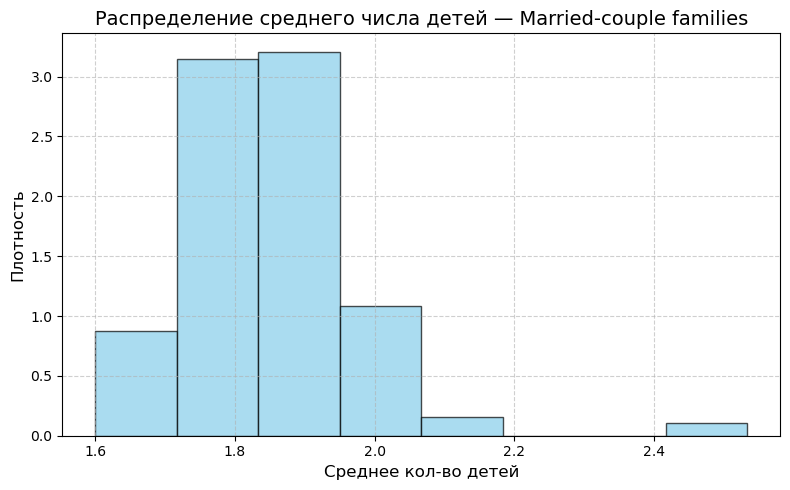

In [5]:
# Для женатых семей
plot_family_hist(married_df, "Married-couple families")

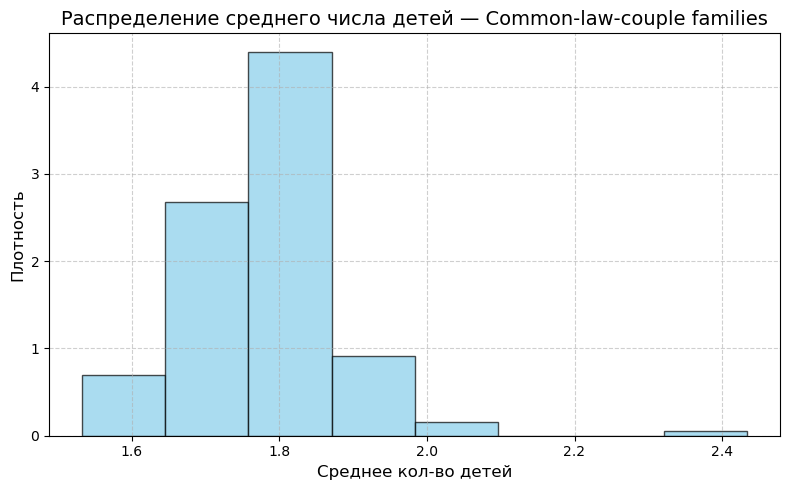

In [6]:
# Для гражданских союзов
plot_family_hist(commonlaw_df, "Common-law-couple families")

**УБираем большие значения**

In [7]:
# married_df =  married_df[ married_df['Среднее кол-во детей']<=2.2]
# commonlaw_df =  commonlaw_df[ commonlaw_df['Среднее кол-во детей']<=2.2]

In [8]:
# Извлекаем значения как массивы
x = married_df['Среднее кол-во детей']
y = commonlaw_df['Среднее кол-во детей']


## Проверка гипотезы о равенстве стредних через доверительный интервал 
(6 слайд теор материалов)
Не использую никаких функций просто вручную вбиваем функцию из презинтации
в интернетах всяких вычитала что это типа z-критерий, но я не знаю так это или не так  `(*>﹏<*)′

In [9]:
import numpy as np
from scipy.stats import norm

def ci_diff_means(x=None, y=None, alpha=0.05):
    """
    Построить доверительный интервал для разницы средних по формуле:
    Δ = ( x̄ - ȳ - u_{1-α/2} * sqrt(sx²/m + sy²/n),  x̄ - ȳ + u_{1-α/2} * sqrt(sx²/m + sy²/n) )

    Возвращает словарь с полным результатом.
    """

    # Если переданы массивы — вычисляем параметры
    if x is not None and y is not None:
        x = np.asarray(x)
        y = np.asarray(y)
        m = x.size
        n = y.size
        mean_x = x.mean() # считаем среднее x̄
        mean_y = y.mean() 
        s2_x = x.var(ddof=1)
        s2_y = y.var(ddof=1)
        print(f"Выборочная дисперсия X (s²ₓ): {s2_x}")
        print(f"Выборочная дисперсия Y (s²ᵧ): {s2_y}")
 
    diff = mean_x - mean_y
    se = np.sqrt(s2_x / m + s2_y / n)
    z_crit = norm.ppf(1 - alpha / 2)

    ci_low = diff - z_crit * se
    ci_high = diff + z_crit * se

    z_stat = diff / se
    p_value = 2 * (1 - norm.cdf(abs(z_stat)))
    reject = (ci_low > 0) or (ci_high < 0)

    return {
        "mean_x": mean_x,
        "mean_y": mean_y,
        "m": m,
        "n": n,
        "diff": diff,
        "se": se,
        "z_crit": z_crit,
        "ci": (ci_low, ci_high),
        "z_stat": z_stat,
        "p_value": p_value,
        "reject_H0": reject,
        "alpha": alpha
    }


In [10]:
res = ci_diff_means(x=x, y=y, alpha=0.05)

for k, v in res.items():
    print(f"{k:10s} : {v}")

Выборочная дисперсия X (s²ₓ): 0.014933471258772453
Выборочная дисперсия Y (s²ᵧ): 0.010333901261612093
mean_x     : 1.8596385542168676
mean_y     : 1.7789156626506024
m          : 166
n          : 166
diff       : 0.08072289156626522
se         : 0.012337466817470921
z_crit     : 1.959963984540054
ci         : (np.float64(0.05654190094356422), np.float64(0.10490388218896622))
z_stat     : 6.542906478334322
p_value    : 6.033462618404428e-11
reject_H0  : True
alpha      : 0.05


## Критерий Андерсона (для проверки нормальности каждого распределения)

In [11]:
from scipy.stats import anderson

# Пример для одной выборки
result = anderson(y, dist='norm')  # dist='norm' для проверки на нормальность

print("Статистика A^2:", result.statistic)
print("Критические значения:", result.critical_values)
print("Уровни значимости (%):", result.significance_level)

# Интерпретация
if result.statistic > result.critical_values[2]:  # например, на уровне 5%
    print("Отвергаем гипотезу о нормальности")
else:
    print("Нет оснований отвергать гипотезу о нормальности")


Статистика A^2: 2.5604186396651016
Критические значения: [0.563 0.641 0.769 0.897 1.067]
Уровни значимости (%): [15.  10.   5.   2.5  1. ]
Отвергаем гипотезу о нормальности


In [12]:
from scipy.stats import anderson

# Пример для одной выборки
result = anderson(x, dist='norm')  # dist='norm' для проверки на нормальность

print("Статистика A^2:", result.statistic)
print("Критические значения:", result.critical_values)
print("Уровни значимости (%):", result.significance_level)

# Интерпретация
if result.statistic > result.critical_values[2]:  # например, на уровне 5%
    print("Отвергаем гипотезу о нормальности")
else:
    print("Нет оснований отвергать гипотезу о нормальности")


Статистика A^2: 3.372484231424039
Критические значения: [0.563 0.641 0.769 0.897 1.067]
Уровни значимости (%): [15.  10.   5.   2.5  1. ]
Отвергаем гипотезу о нормальности


## МАННА-УИТНИ U-ТЕСТ Для проверки гипотезы о равенстве распределений 

In [13]:
# Импортируем библиотеки
import pandas as pd
from scipy.stats import mannwhitneyu

# Пример — если твои датафреймы уже есть в памяти:
# married_df и commonlaw_df
# допустим, у них есть столбец "Среднее кол-во детей"

# --- МАННА-УИТНИ U-ТЕСТ ---

# Используем параметр alternative='two-sided', т.к. хотим проверить, отличаются ли выборки вообще
# parameter 'method' позволяет указать, как считать p-value при больших выборках:
# 'exact' — для маленьких выборок (n1 + n2 <= 20)
# 'asymptotic' — для больших выборок (n1 + n2 > 20), используется нормальное приближение


result = mannwhitneyu(x, y, use_continuity=True, alternative='two-sided', method='auto', nan_policy='propagate', keepdims=False)

# Выводим результаты
print("=== Результаты теста Манна–Уитни ===")
print(f"U-статистика: {result.statistic:.4f}")
print(f"p-value: {result.pvalue:.6f}")

# --- Интерпретация ---
alpha = 0.05  # уровень значимости
if result.pvalue < alpha:
    print(f"Отвергаем H0 при α = {alpha}: распределения различаются.")
else:
    print(f"Не отвергаем H0 при α = {alpha}: статистически значимых различий не обнаружено.")


=== Результаты теста Манна–Уитни ===
U-статистика: 19937.5000
p-value: 0.000000
Отвергаем H0 при α = 0.05: распределения различаются.


## Загрузка дополнительных данных для Критерия Пирсона

In [14]:

# --- 1. Загружаем данные об уровне образования ---
edu_df = pd.read_excel("люди_образование.xlsx")

# Фильтруем только год 2021 и все возрастные группы/пол
edu_df = edu_df[
    (edu_df['REF_DATE'] == 2021) &
    (edu_df['Age (15A)'] == 'Total - Age') &
    (edu_df['Gender (3a)'] == 'Total - Gender')
]

# Присваиваем каждой категории образования числовой балл
education_mapping = {
    'No certificate, diploma or degree': 0,
    'High (secondary) school diploma or equivalency certificate': 1,
    'Postsecondary certificate, diploma or degree': 2,
    'Apprenticeship or trades certificate or diploma': 2,
    'Non-apprenticeship trades certificate or diploma': 2,
    "Apprenticeship certificate": 2,
    "Total - Highest certificate, diploma or degree": None  # Игнорируем суммарную строку
}

edu_df['Education_score'] = edu_df['Highest certificate, diploma or degree (15)'].map(education_mapping)

# Убираем строки без балла
edu_df = edu_df.dropna(subset=['Education_score'])

# --- 2. Считаем средний уровень образования по региону ---
# Процент в колонке 'Census year (4):2021[1]'
edu_df['Weighted_score'] = edu_df['Census year (4):2021[1]'] * edu_df['Education_score']

# Суммируем по регионам
avg_edu_by_region = edu_df.groupby('GEO').agg({'Weighted_score': 'sum', 'Census year (4):2021[1]': 'sum'})

# Вычисляем средневзвешенный уровень образования
avg_edu_by_region['Average_Education'] = avg_edu_by_region['Weighted_score'] / avg_edu_by_region['Census year (4):2021[1]']
avg_edu_by_region = avg_edu_by_region[['Average_Education']].reset_index()

# Переименовываем для удобства
married_df = married_df.rename(columns={
    "Регион": "GEO"
})

# Переименовываем для удобства
commonlaw_df = commonlaw_df.rename(columns={
    "Регион": "GEO"
})


In [15]:

# --- 3. Объединяем с данными о детях ---
# Для брачных семей
married_edu_df = pd.merge(married_df, avg_edu_by_region, on='GEO')

# Для семей в гражданском браке
commonlaw_edu_df = pd.merge(commonlaw_df, avg_edu_by_region, on='GEO')

# Переименовываем для удобства
married_edu_df = married_edu_df.rename(columns={
    "GEO": "Регион"
})

# Переименовываем для удобства
commonlaw_edu_df = commonlaw_edu_df.rename(columns={
    "GEO": "Регион"
})


# --- 4. Итоговые датафреймы ---
print("Married families with education:\n", married_edu_df.head())
print("Common-law families with education:\n", commonlaw_edu_df.head())

Married families with education:
                              Регион  Среднее кол-во детей  Average_Education
0  Abbotsford - Mission (CMA), B.C.              2.000000           1.370543
1                           Alberta              1.933333           1.491194
2                   Alma (CA), Que.              1.866667           1.593945
3                   Amos (CA), Que.              1.966667           1.510975
4            Baie-Comeau (CA), Que.              1.700000           1.543668
Common-law families with education:
                              Регион  Среднее кол-во детей  Average_Education
0  Abbotsford - Mission (CMA), B.C.              1.800000           1.370543
1                           Alberta              1.800000           1.491194
2                   Alma (CA), Que.              1.833333           1.593945
3                   Amos (CA), Que.              1.933333           1.510975
4            Baie-Comeau (CA), Que.              1.733333           1.543668


## Критерий Пирсона

In [17]:
# Требуемые библиотеки
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

def chi2_for_df(df, family_label='Married'):
    """
    Принимает dataframe с колонками:
      - 'Регион'
      - 'Среднее кол-во детей'      (numeric)
      - 'Average_Education'        (numeric)
    Делает категоризацию по квантилям (3 категории), строит таблицу сопряжённости и применяет chi2.
    Выводит таблицу, ожидаемые частоты, chi2, df, p и минимальное ожидаемое значение.
    """
    data = df.copy()

    # 1) Категоризация: используем qcut, чтобы получить примерно равные по объёму категории.
    # Если в данных мало уникальных значений, qcut может выбросить ошибку — в таком случае используем cut с запасом.
    try:
        data['edu_cat'] = pd.qcut(data['Average_Education'], q=3,
                                  labels=['низкий', 'средний', 'высокий'], duplicates='drop')
    except Exception:
        # запасной вариант: равные интервалы
        data['edu_cat'] = pd.cut(data['Average_Education'], bins=3,
                                 labels=['низкий', 'средний', 'высокий'])

    try:
        data['children_cat'] = pd.qcut(data['Среднее кол-во детей'], q=3,
                                       labels=['мало', 'средне', 'много'], duplicates='drop')
    except Exception:
        data['children_cat'] = pd.cut(data['Среднее кол-во детей'], bins=3,
                                      labels=['мало', 'средне', 'много'])

    # 2) Таблица сопряжённости
    table = pd.crosstab(data['edu_cat'], data['children_cat'])
    print(f"\n=== {family_label} — таблица сопряжённости ===")
    print(table)

    # 3) Применение chi2
    chi2, p, dof, expected = chi2_contingency(table, correction=False)  # без Yates' correction для общих таблиц 
                                                                        #Установка correction=False означает, что вы используете стандартный 
                                                                        #расчет критерия хи-квадрат без этой коррекции, 
                                                                        #что предпочтительнее для больших выборок
    print(f"\nχ² = {chi2:.4f}, df = {dof}, p-value = {p:.6f}")

    # 4) Ожидаемые частоты
    expected_df = pd.DataFrame(expected, index=table.index, columns=table.columns)
    print("\nОжидаемые частоты (expected):")
    print(expected_df)

    # 5) Проверка минимальной ожидаемой частоты
    min_expected = expected.min()
    print("\nМинимальные ожидаемые частоты по ячейкам:")
    print(min_expected.min())

    if expected.min() < 5:
        print("\nВНИМАНИЕ: есть ячейки с ожидаемой частотой < 5. Рекомендации:")
        print("- объединить соседние категории (например, 'мало'+'средне') или")
        print("- уменьшить число категорий (2 вместо 3) или")
        print("- если таблица 2x2 и ожидаемые частоты малы — использовать тест Фишера (fisher_exact)")
    else:
        print("\nУсловие по ожидаемым частотам (>=5) выполняется — результат χ² корректен при выбранном разбиении.")

    return {'table': table, 'chi2': chi2, 'p': p, 'dof': dof, 'expected': expected_df}

res_married = chi2_for_df(married_edu_df, family_label='Married families')
res_commonlaw = chi2_for_df(commonlaw_edu_df, family_label='Common-law families')


=== Married families — таблица сопряжённости ===
children_cat  мало  средне  много
edu_cat                          
низкий          17      19     20
средний         22      21     12
высокий         26      21      8

χ² = 7.5627, df = 4, p-value = 0.108976

Ожидаемые частоты (expected):
children_cat       мало     средне      много
edu_cat                                      
низкий        21.927711  20.578313  13.493976
средний       21.536145  20.210843  13.253012
высокий       21.536145  20.210843  13.253012

Минимальные ожидаемые частоты по ячейкам:
13.25301204819277

Условие по ожидаемым частотам (>=5) выполняется — результат χ² корректен при выбранном разбиении.

=== Common-law families — таблица сопряжённости ===
children_cat  мало  средне  много
edu_cat                          
низкий           9      26     21
средний         26      18     11
высокий         28      13     14

χ² = 18.2341, df = 4, p-value = 0.001111

Ожидаемые частоты (expected):
children_cat       мал

# Более красивые гистограммы

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def analyze_data(data, column=None, bins="auto"):
    """
    Анализ данных: вариационный ряд, группировка и гистограмма с KDE.
    
    Parameters
    ----------
    data : pandas.DataFrame, list или np.array
        Исходные данные (может быть DataFrame с числовыми значениями).
    column : str, optional
        Название столбца для анализа (если передан DataFrame).
    bins : int, str или последовательность, optional
        Количество или способ выбора интервалов для гистограммы (по умолчанию "auto").
    """

    # --- Извлечение данных ---
    if column is not None:
        # Если подан DataFrame, извлекаем нужный столбец
        if hasattr(data, "loc"):
            series = data[column].dropna().values
        else:
            raise TypeError("Если указан параметр 'column', аргумент 'data' должен быть DataFrame.")
    else:
        # Если это просто список или массив
        series = np.asarray(data)
    
    # --- Преобразование к числам ---
    series = pd.to_numeric(series, errors='coerce')
    series = series[~np.isnan(series)]  # удаляем NaN

    n = len(series)
    print(f"\nАнализ столбца: {column if column else 'не указан (все данные)'}")
    print(f"Количество наблюдений: {n}")

    # --- Определяем число интервалов ---
    if bins == "auto":
        k = int(1 + 3.3 * np.log10(n))
        bins = k
        print(f"Число интервалов (по формуле Стерджесса): k = {k}")

    # --- Вариационный ряд ---
    variation_series = np.sort(series)
    print("\nВариационный ряд (фрагментарно):")
    if n >= 15:
        print("Первые 5:", variation_series[:5])
        print("Средние 5:", variation_series[n//2 - 2:n//2 + 3])
        print("Последние 5:", variation_series[-5:])
    else:
        print(variation_series)

    # --- Группированный статистический ряд ---
    counts, bin_edges = np.histogram(series, bins=bins)
    print("\nГруппированный статистический ряд (интервалы и частоты):")
    for i in range(len(counts)):
        print(f"[{bin_edges[i]:.2f}, {bin_edges[i+1]:.2f}) : {counts[i]}")

    # --- Гистограмма ---
    plt.hist(series, bins=bin_edges, density=True, alpha=0.5,
             color='skyblue', edgecolor='black', label='Гистограмма')

    # --- KDE (ядровая оценка плотности) ---
    kde = gaussian_kde(series)
    x_grid = np.linspace(min(series), max(series), 500)
    plt.plot(x_grid, kde(x_grid), color='red', linewidth=2, label='Эмпирическая плотность (KDE)')

    plt.title(f"Гистограмма и эмпирическая плотность распределения\n({column if column else 'данные'})")
    plt.xlabel("Значения")
    plt.ylabel("Плотность")
    plt.legend()
    plt.show()

    return variation_series, (bin_edges, counts), kde


Анализ столбца: Среднее кол-во детей
Количество наблюдений: 166
Число интервалов (по формуле Стерджесса): k = 8

Вариационный ряд (фрагментарно):
Первые 5: [1.6 1.6 1.6 1.6 1.6]
Средние 5: [1.86666667 1.86666667 1.86666667 1.86666667 1.86666667]
Последние 5: [2.06666667 2.06666667 2.06666667 2.46666667 2.53333333]

Группированный статистический ряд (интервалы и частоты):
[1.60, 1.72) : 17
[1.72, 1.83) : 61
[1.83, 1.95) : 62
[1.95, 2.07) : 21
[2.07, 2.18) : 3
[2.18, 2.30) : 0
[2.30, 2.42) : 0
[2.42, 2.53) : 2


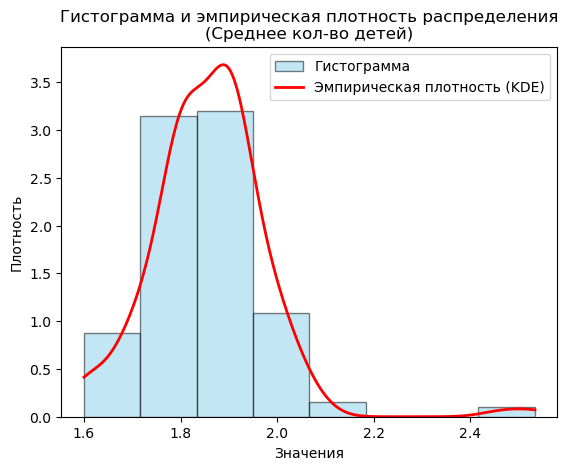

In [19]:
# Передаём датафрейм df_jan_clean и нужный столбец
variation_series_married, grouped, kde = analyze_data(
    married_df,
    column="Среднее кол-во детей"
)


Анализ столбца: Среднее кол-во детей
Количество наблюдений: 166
Число интервалов (по формуле Стерджесса): k = 8

Вариационный ряд (фрагментарно):
Первые 5: [1.53333333 1.6        1.6        1.6        1.6       ]
Средние 5: [1.76666667 1.76666667 1.76666667 1.76666667 1.76666667]
Последние 5: [1.96666667 2.         2.03333333 2.03333333 2.43333333]

Группированный статистический ряд (интервалы и частоты):
[1.53, 1.65) : 13
[1.65, 1.76) : 50
[1.76, 1.87) : 82
[1.87, 1.98) : 17
[1.98, 2.10) : 3
[2.10, 2.21) : 0
[2.21, 2.32) : 0
[2.32, 2.43) : 1


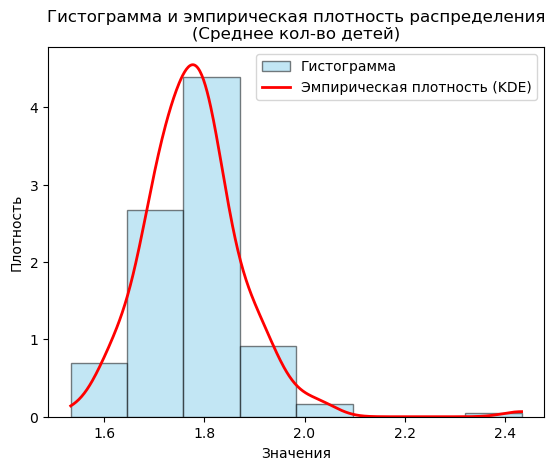

In [20]:
# Передаём датафрейм df_jan_clean и нужный столбец
variation_series_commonlaw, grouped, kde = analyze_data(
    commonlaw_df,
    column="Среднее кол-во детей"
)